# AutoEncoders

> Collection of Autoencoder models

In [ ]:
#| default_exp models.autoencoders

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from lightning import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.tuner.tuning import Tuner
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

from hydra.utils import instantiate
from omegaconf import OmegaConf
from pprint import pprint

from matplotlib import pyplot as plt
import pandas as pd

from nimrod.image.datasets import ImageDataset
from nimrod.modules import Encoder, Decoder
from nimrod.models.conv import ConvLayer, ConvNet, ConvNetX
from nimrod.utils import time_it, set_seed

import logging
import warnings

In [ ]:
#| export
set_seed(42)
logger = logging.getLogger(__name__)
# logger.setLevel(logging.DEBUG)
plt.set_loglevel('INFO')
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

Seed set to 42


## Fashion MNIST

In [ ]:
cfg = OmegaConf.load('../config/data/image/image.yaml')
dm = instantiate(cfg, name='fashion_mnist', data_dir='../data/image/')
dm.prepare_data()
dm.setup()
print(dm.num_classes)

[22:06:36] INFO - Init ImageDataModule for fashion_mnist
[22:06:56] INFO - split train into train/val [0.8, 0.2]
[22:06:56] INFO - train: 48000 val: 12000, test: 10000


10


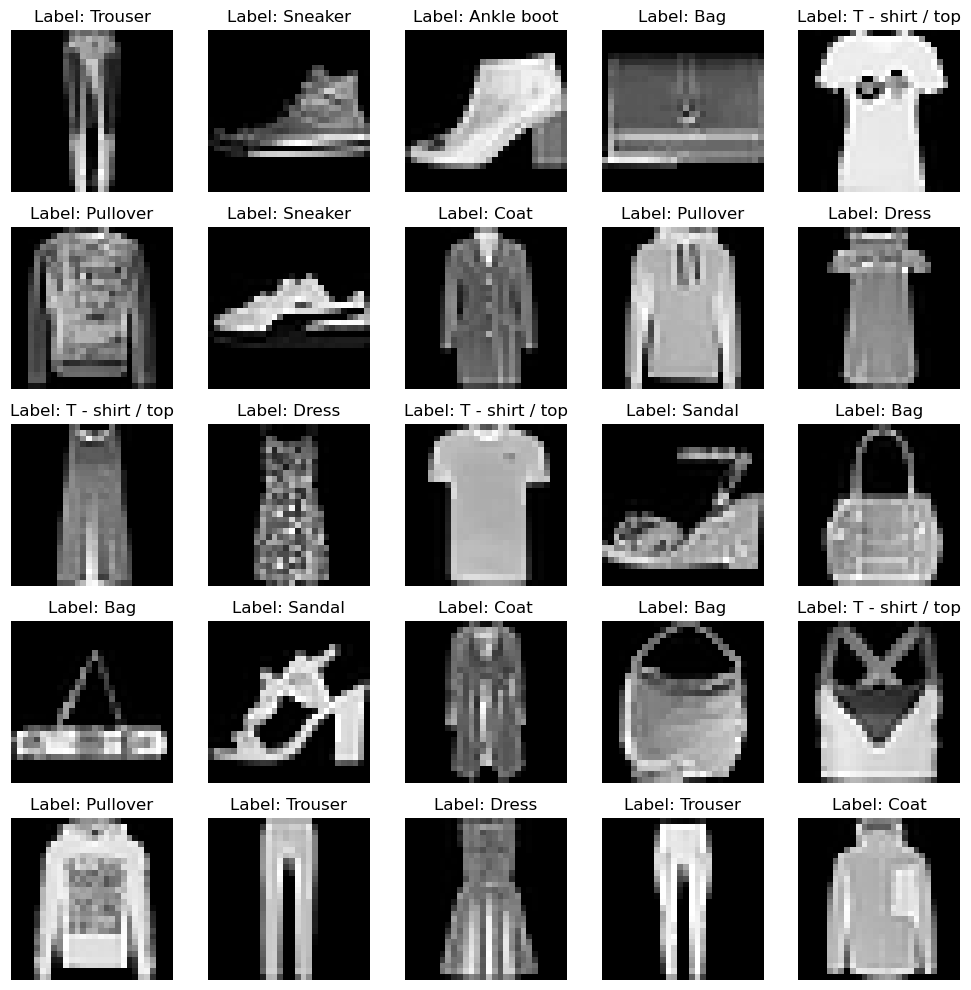

In [ ]:
dm.show_grid(5,5)

In [ ]:
print(dm.label_names)

['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### ConvNet

In [ ]:
cfg = OmegaConf.load('../config/model/image/convnetx_adam.yaml')
# nnet = instantiate(cfg.nnet, num_classes=dm.num_classes)
# optimizer = instantiate(cfg.optimizer)
# scheduler = instantiate(cfg.scheduler)

# model = ConvNetX(nnet, dm.num_classes, optimizer, scheduler)
model = instantiate(cfg, num_classes=dm.num_classes)

[22:06:57] INFO - ConvNetX: init
[22:06:57] INFO - Classifier: init
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.


In [ ]:
#| notest
MAX_EPOCHS = 5
dm.batch_size = 256
print(dm.batch_size)
# lr = 0.4

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    logger=CSVLogger("logs", name="fashion_mnist_convnet"),
    callbacks = [LearningRateMonitor(logging_interval="step")],
    check_val_every_n_epoch=1,
    log_every_n_steps=1
    )


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


256


### LR Finder

[22:09:59] INFO - Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.06
    maximize: False
    weight_decay: 0
)
[22:09:59] INFO - Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object>
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:316: The lr scheduler dict contains the key(s) ['monitor', 'strict'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packa

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 9.120108393559098e-06
Restoring states from the checkpoint path at /Users/slegroux/Projects/nimrod/nbs/.lr_find_5828b967-b82f-4e1a-bda1-997d275f4d03.ckpt
Restored all states from the checkpoint at /Users/slegroux/Projects/nimrod/nbs/.lr_find_5828b967-b82f-4e1a-bda1-997d275f4d03.ckpt


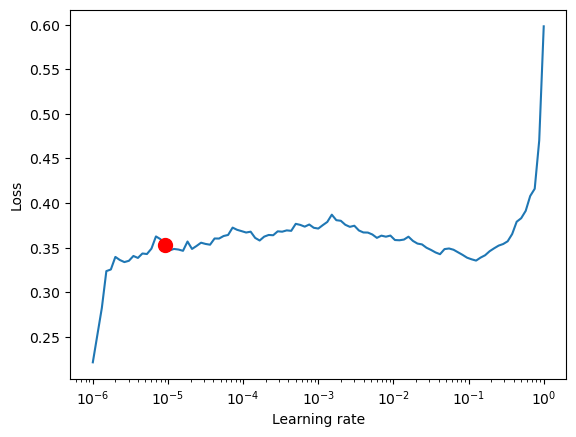

Suggested learning rate: 9.120108393559098e-06


In [ ]:
#| notest
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(
    model,
    datamodule=dm,
    min_lr=1e-6,
    max_lr=1.0,
    num_training=100,  # number of iterations
    # attr_name="optimizer.lr",
)
fig = lr_finder.plot(suggest=True)
plt.show()
print(f"Suggested learning rate: {lr_finder.suggestion()}")

In [ ]:
# print(f"lr: {model.lr}, bs: {dm.batch_size}")

lr: 9.120108393559098e-06, bs: 256


### Fit

In [ ]:
#| notest

cfg.optimizer.lr = 0.4
print(OmegaConf.to_yaml(cfg))

model = instantiate(cfg)
trainer.fit(model, dm.train_dataloader(), dm.val_dataloader())


[22:10:36] INFO - ConvNetX: init
[22:10:36] INFO - Classifier: init


_target_: nimrod.models.conv.ConvNetX
num_classes: 10
nnet:
  _target_: nimrod.models.conv.ConvNet
  n_features:
  - 1
  - 8
  - 16
  - 32
  - 64
  num_classes: ${..num_classes}
  kernel_size: 3
  bias: null
  normalization:
    _target_: hydra.utils.get_class
    path: torch.nn.BatchNorm2d
  activation:
    _target_: hydra.utils.get_class
    path: torch.nn.ReLU
optimizer:
  _target_: torch.optim.Adam
  _partial_: true
  lr: 0.4
scheduler:
  _target_: torch.optim.lr_scheduler.ReduceLROnPlateau
  _partial_: true
  mode: min
  factor: 0.1
  patience: 5



/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.
[22:10:54] INFO - Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.4
    maximize: False
    weight_decay: 0
)
[22:10:54] INFO - Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object>

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | loss         | CrossEntropyLoss   | 0      | train
1 | train_acc    | MulticlassAccuracy | 0      | train
2 | val_acc      | MulticlassAccuracy | 0      | train
3 | test_acc     | MulticlassAccuracy | 0      | train
4 | train_loss   | MeanMetric         | 0      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[22:11:24] INFO - scheduler is an instance of Reduce plateau


Validation: |          | 0/? [00:00<?, ?it/s]

[22:11:54] INFO - scheduler is an instance of Reduce plateau


Validation: |          | 0/? [00:00<?, ?it/s]

[22:12:24] INFO - scheduler is an instance of Reduce plateau


Validation: |          | 0/? [00:00<?, ?it/s]

[22:12:55] INFO - scheduler is an instance of Reduce plateau


Validation: |          | 0/? [00:00<?, ?it/s]

[22:13:25] INFO - scheduler is an instance of Reduce plateau
`Trainer.fit` stopped: `max_epochs=5` reached.


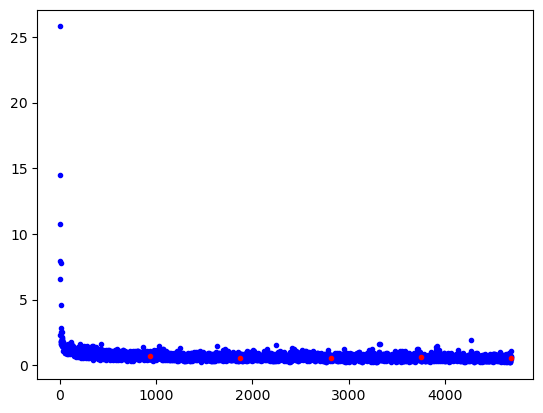

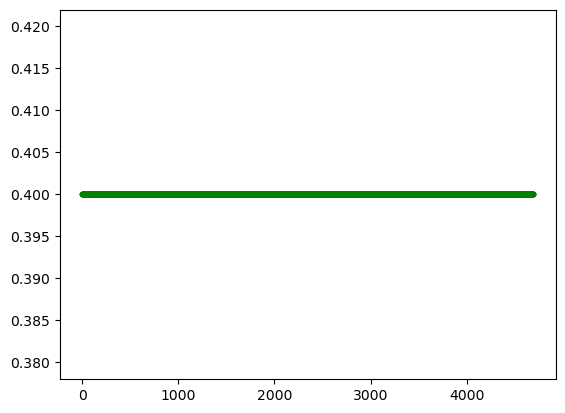

In [ ]:
#| notest



########################
csv_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(csv_path)
metrics.head()

#########################
plt.figure()
plt.plot(metrics['step'], metrics['train/loss_step'], 'b.-')
plt.plot(metrics['step'], metrics['val/loss'],'r.-')
plt.figure()
plt.plot(metrics['step'], metrics['lr-Adam'], 'g.-')
plt.show()

In [ ]:
#| notest
trainer.test(model, dm.test_dataloader())

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │     0.803600013256073     │
│         test/loss         │    0.5951264500617981     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.5951264500617981, 'test/acc': 0.803600013256073}]

In [ ]:
#| export
class AutoEncoder(nn.Module):
    """ A modular autoencoder with configurable encoder and decoder """
    def __init__(self,
        encoder:nn.Module, # Encoder layer
        decoder:nn.Module # Decoder layer
        ):

        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(
        self,
        x:torch.Tensor # Tensor B x C X H X W
        )->torch.Tensor: # Reconstructed input tensor of shape B x C X H X W

        """
        Forward pass of the AutoEncoder model.
        """

        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [ ]:
show_doc(AutoEncoder.forward)

---

### AutoEncoder.forward

>      AutoEncoder.forward (x:torch.Tensor)

*Forward pass of the AutoEncoder model.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x | Tensor | Tensor B x C X H X W |
| **Returns** | **Tensor** | **Reconstructed input tensor of shape B x C X H X W** |

In [ ]:
enc = Encoder()
dec = Decoder()
a = AutoEncoder(enc, dec)
batch = torch.rand((10, 28*28))
y = a(batch)
print(y.shape)

torch.Size([10, 784])


In [ ]:
#| notest
ds = ImageDataset(name='fashion_mnist', data_dir='../data/image/')
dl = DataLoader(ds)
b = next(iter(dl))
print(len(b), b[0].shape, b[1].shape)


2 torch.Size([1, 1, 28, 28]) torch.Size([1])


## AutoEncoder_X

In [ ]:
#| export
class AutoEncoderPL(LightningModule):
    """ LightningModule for AutoEncoder """
    def __init__(
        self,
        autoencoder:AutoEncoder # AutoEncoder instance
        ):
        super().__init__()
        # self.save_hyperparameters()
        self.save_hyperparameters(ignore=['autoencoder'])
        self.autoencoder = autoencoder
        self.metric = torch.nn.MSELoss()

    def forward(
        self,
        x: torch.Tensor # Tensor B x L
        )->torch.Tensor: # Reconstructed input tensor of shape B x L
        """
        Forward pass of the AutoEncoder model.
        """
        return self.autoencoder(x)
    
    def predict_step(self, batch, batch_idx):
        """
        Forward pass of the AutoEncoder model.
        """
        x, y = batch
        x = x.view(x.size(0), -1)
        with torch.no_grad():
            return self.autoencoder(x)

    def _shared_eval(self, batch, batch_idx, prefix, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True):
        x, _ = batch
        x = x.view(x.size(0), -1) # flatten B x C x H x W to B x L (grey pic)
        x_hat = self.autoencoder(x)
        loss = self.metric(x_hat, x)
        self.log(f"{prefix}/loss", loss, on_step=on_step, on_epoch=on_epoch, sync_dist=sync_dist)
        return loss

    def training_step(self, batch, batch_idx):
        return self._shared_eval(batch, batch_idx, "train")
    
    def test_step(self, batch, batch_idx):
        self._shared_eval(batch, batch_idx, "test")
    
    def validation_step(self, batch, batch_idx):
        return self._shared_eval(batch, batch_idx, "val")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [ ]:
show_doc(AutoEncoderPL.forward)

---

### AutoEncoderPL.forward

>      AutoEncoderPL.forward (x:torch.Tensor)

*Forward pass of the AutoEncoder model.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x | Tensor | Tensor B x L |
| **Returns** | **Tensor** | **Reconstructed input tensor of shape B x L** |

In [ ]:
#| hide
# def on_validation_batch_end(
#         self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx, wadn
#         ):
#         # `outputs` comes from `LightningModule.validation_step`
#         # which corresponds to our model predictions in this case
        
#         # Let's log 20 sample image predictions from the first batch
#         if batch_idx == 0:
#             n = 20
#             x, y = batch
#             images = [img for img in x[:n]]
#             captions = [f'Ground Truth: {y_i} - Prediction: {y_pred}' 
#                 for y_i, y_pred in zip(y[:n], outputs[:n])]
            
            
#             # Option 1: log images with `WandbLogger.log_image`
#             wandb_logger.log_image(
#                 key='sample_images', 
#                 images=images, 
#                 caption=captions)


In [ ]:
autoencoder_pl = AutoEncoderPL(a)
b = torch.rand((5,28*28))
y = autoencoder_pl(b)
print(y.shape)

torch.Size([5, 784])


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()